# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sqla
import sqlite3
%matplotlib inline
plt.style.use('ggplot')

In [3]:
sqlite_file = "./sf_data.sqlite"
sf_conn = sqla.create_engine('sqlite:///' + sqlite_file)

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

We left join the schedule and permit table by permit column. In this way, we have all the locations information. Also, we also make the connection to the permit table. Therefore, we can find out the location record belongs to which company. 

In [5]:
sql_query = """
select * from mobile_food_schedule as a 
left join mobile_food_permits as b
on a.permit = b.permit;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)

The top 10 vendors who sell at the most locations are shown below. 

In [9]:
sql_query = """
select Applicant, count(distinct locationid) as count from mobile_food_schedule as a 
left join mobile_food_permits as b
on a.permit = b.permit
group by Applicant
order by count desc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.head(n=10)

,Applicant,count
0,May Catering,58
1,Anas Goodies Catering,37
2,Natan's Catering,37
3,Liang Bai Ping,33
4,Park's Catering,23
5,Singh Brothers Ice Cream,21
6,John's Catering #5,19
7,Mang Hang Catering,19
8,Sun Rise Catering,19
9,D & T Catering,17


Therefore, May Catering sells at the most locations. 

__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

In [10]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
from matplotlib.patches import Circle, Wedge, Polygon

### **Q1: Which parts of the city are the most dangerous and at what times, also which type of crimes are reported in the region with the most crime reported?**

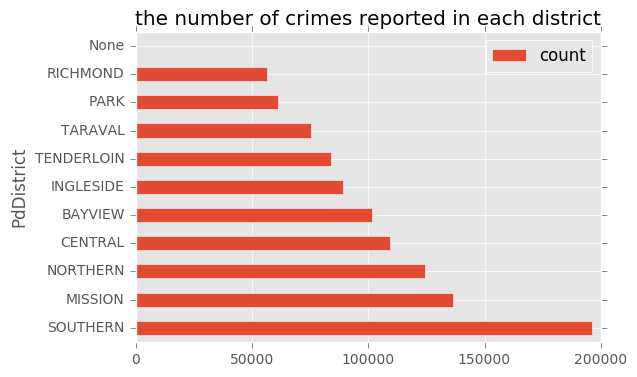

In [11]:
sql_query = """
select PdDistrict, count(*) as count 
from crime
group by PdDistrict
order by count desc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.plot.barh(x=selected_table.PdDistrict, title = 'the number of crimes reported in each district')

From the plot above, we can see Southern District has the most crimes reported. We would like to see at what time, it is the most dangerous in this region. 

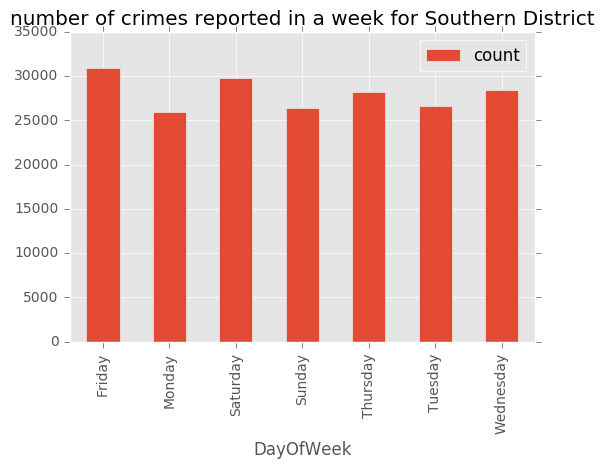

In [33]:
sql_query = """
select DayOfWeek, count(*) as count 
from crime
where PdDistrict = 'SOUTHERN'
group by DayOfWeek;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.plot.bar(x=selected_table.DayOfWeek, title="number of crimes reported in a week for Southern District")

Therefore, the most crimes are reported on Friday in Southern District. We can see the number of prices are going up and down. Now, we would like to see in Southern District, what time of crimes reported the most. 

In [15]:
sql_query = """
select Category, count(*) as count
from crime
where PdDistrict = 'SOUTHERN'
group by Category
order by count desc
;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.head()

,Category,count
0,LARCENY/THEFT,60068
1,NON-CRIMINAL,25576
2,OTHER OFFENSES,23811
3,ASSAULT,15114
4,WARRANTS,10347


We can see, in Southern District, the LARCENY/THEFT crime report received the most. It is much higher than other crime type. Now, we will check which time of any particular day has the most number of crime reported. 

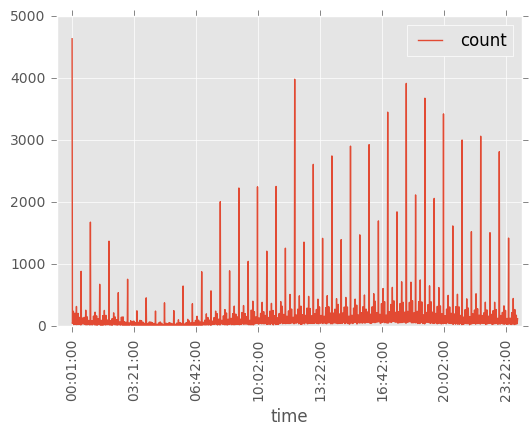

In [16]:
sql_query = """
select 
time(Datetime) as time, 
count(*) as count
from crime
where PdDistrict = 'SOUTHERN'
group by time;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.plot(x=selected_table.time, rot=90, xlim=[-50, 1450])

Therefore, midnight has the most crime reported in Southern district. 

An interactive plot show the total number of crimes in different district in San Francisco are given below. 

In [89]:
sql_query = """
select PdDistrict, count(*) as count 
from crime
group by PdDistrict
order by count desc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.columns = ['Location', 'Count']
SF_COORDINATES = (37.7749, -122.4194)

In [90]:
import folium
district_geo = r'sfpddistricts.geojson'
map1 = folium.Map(location=SF_COORDINATES, zoom_start=12)
map1.choropleth(
    geo_path = district_geo, 
    data = selected_table, 
    columns=['Location', 'Count'], 
    key_on = 'feature.properties.DISTRICT', 
    fill_color = 'YlGn', 
    fill_opacity = 0.7, 
    line_opacity = 0.4, 
    legend_name = 'Number of crimes reported per district')
map1

### **Q2: Which parts of the city are the most and least expensive, and which region has the highest turnover rate?**

First, the most and least expensive region are determined by the region which has the highest or lowest median sold price per square feet for all home. 

In [21]:
sql_query = """
select RegionName, AVG(MedianSoldPricePerSqft_AllHomes) as avgMedianSoldPrice from zillow
group by RegionName
order by avgMedianSoldPrice desc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.head(n=10)

,RegionName,avgMedianSoldPrice
0,94104,1336.128581
1,94105,798.257824
2,94123,696.166788
3,94158,657.211820
4,94114,650.127729
5,94133,638.636839
6,94102,626.417276
7,94109,618.325709
8,94115,611.771452
9,94103,604.009929


The table above is sort by the average median sold price per square feet in each regoin. The region with the highest average median sold price per square feet is the region 94194. If we check the map, it is the region close to the Financial Distrist in Download San Francisco. Therefore, it is reasonable that it has the highest average median sold price per square feet. The region with the lowest average median sold price per Sqft is given below. 

In [22]:
sql_query = """
select RegionName, AVG(MedianSoldPricePerSqft_AllHomes) as avgMedianSoldPrice from zillow
group by RegionName
order by avgMedianSoldPrice asc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.head(n=10)

,RegionName,avgMedianSoldPrice
0,94124,297.008046
1,94134,347.027455
2,94080,375.629802
3,94132,385.384982
4,94112,416.744886
5,94111,445.680441
6,94122,453.210167
7,94116,466.570200
8,94121,467.890585
9,94127,490.745386


From the table above, region 94124 has the cheap home to sell. The average median sold price per sqft is just 297USD. 

In [34]:
sql_query = """
select RegionName, AVG(Turnover_AllHomes) as TurnOverRate from zillow
group by RegionName
order by TurnOverRate desc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.head(n=10)

,RegionName,TurnOverRate
0,94104,14.831512
1,94158,11.872355
2,94103,7.188214
3,94107,7.049942
4,94105,6.928359
5,94108,6.620130
6,94109,6.579195
7,94102,6.538972
8,94111,6.521255
9,94115,5.970940


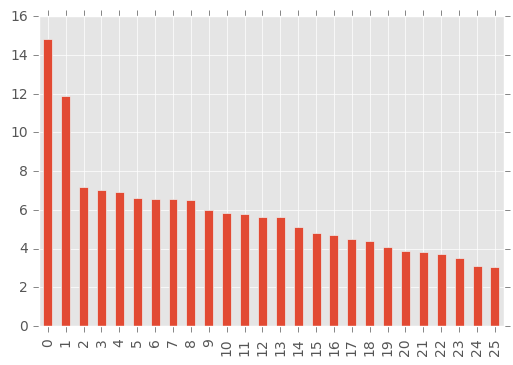

In [58]:
selected_table['TurnOverRate'].plot.bar(x=selected_table['RegionName'])

From the table and bar chart above, we found that the region 94104 has highest turnover rate. The turnover rate is the percentage of all homes in a given area that sold in the past 12 months. In other words, people always buy and sell very often in this region. The region also has the higest average price per square feet. The region 94158 also has very high turnover rate. 

### **Q3: Which Neighborhood received the most noise complaints? Which type of complaints received the most in the data?**

In [62]:
sql_query = """
select Neighborhood, count(Type) as count from noise 
group by Neighborhood
order by count desc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.head(n=10)

,Neighborhood,count
0,None,545
1,South of Market,480
2,Mission,386
3,Outer Sunset,254
4,Lower Nob Hill,173
5,Civic Center,121
6,Mission Dolores,121
7,Tenderloin,116
8,Nob Hill,108
9,Pacific Heights,92


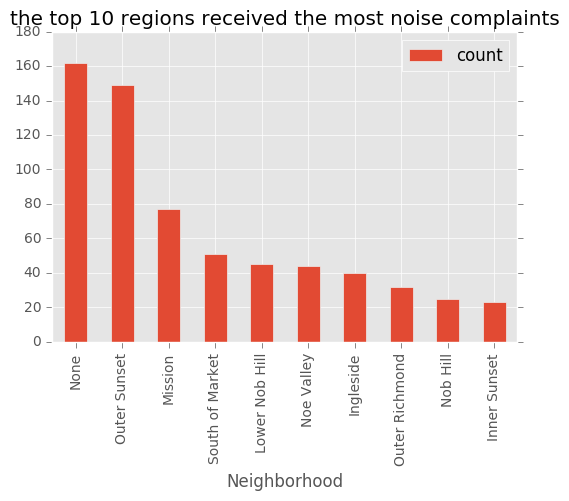

In [73]:
selected_table[0:10].plot.bar(x=selected_table.Neighborhood[0:10], title='the top 10 regions received the most noise complaints')

From the table above, we can see South of Market received the most complaints. Now, we will try to find which type of complaints received the most in the dataset. 

In [69]:
sql_query = """
select Type, count(Type) as count from noise 
group by Type
order by count desc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.head(n=10)

,Type,count
0,other_excessive_noise,1222
1,construction_private_property,795
2,amplified_sound_electronics,499
3,construction_public,386
4,mechanical_equipment,367
5,entertainment,331
6,garbage_recycling_collection,261
7,traffic,206
8,other_reallocate,200
9,major_event_venue,143


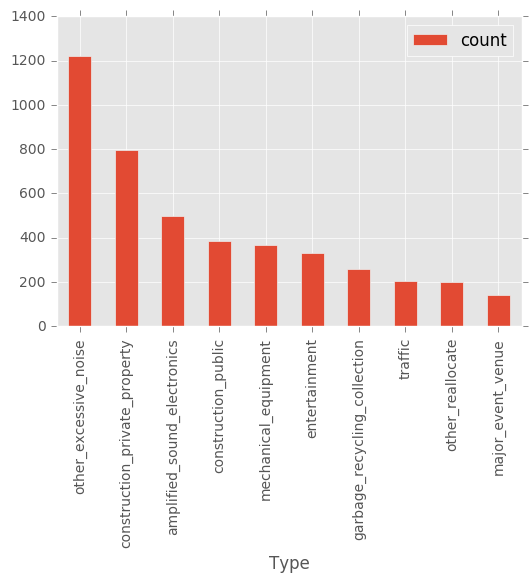

In [70]:
selected_table[0:10].plot.bar(x=selected_table.Type[0:10])

We can see most complaint is about other excessive noise. Now, we would like to further analysis which region received the most complain from this type of noise complaint (i.e. other excessive noise)

In [72]:
sql_query = """
select Neighborhood, count(*) as count from noise 
where Type = 'other_excessive_noise'
group by Neighborhood
order by count desc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.head(n=10)

,Neighborhood,count
0,None,162
1,Outer Sunset,149
2,Mission,77
3,South of Market,51
4,Lower Nob Hill,45
5,Noe Valley,44
6,Ingleside,40
7,Outer Richmond,32
8,Nob Hill,25
9,Inner Sunset,23


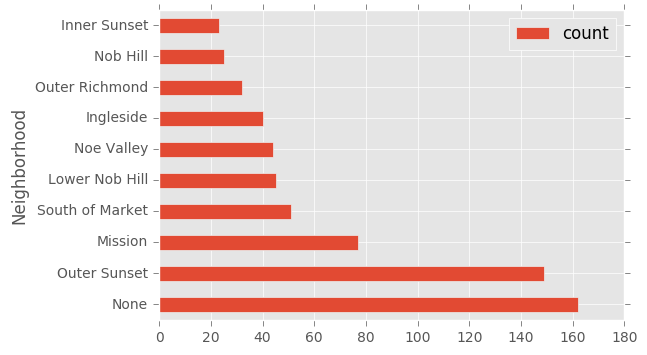

In [75]:
selected_table[0:10].plot.barh(x=selected_table.Neighborhood[0:10])

For the observations related to 'other_excessive_noise complaint', Outer Sunset region received the most noise complaint from this type. It is double of the same type of complaints received in Mission region. As we recall, South Market neighborhood received the most counts of noise report. We would like to see the most complaints in that region is related to which type. 

In [76]:
sql_query = """
select Type, count(*) as count from noise 
where Neighborhood = 'South of Market'
group by Type
order by count desc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table.head(n=10)

,Type,count
0,construction_private_property,100
1,traffic,66
2,construction_public,60
3,other_excessive_noise,51
4,entertainment,45
5,amplified_sound_electronics,42
6,mechanical_equipment,28
7,major_event_venue,26
8,garbage_recycling_collection,20
9,other_reallocate,13


As we can see, for South of Market, the type of noise complaints received the most is construction private property noise complain. 

### **Q4: How many different type of parks in SF? For each type of parks, what is the average Acreage? Which park has the largest acreage? What is its address?**

In [97]:
sql_query = """
select Type, count(*) 
from parks
group by Type;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table

,Type,count(*)
0,Civic Plaza or Square,10
1,Community Garden,18
2,Concession,2
3,Family Camp,1
4,Mini Park,45
5,Neighborhood Park or Playground,131
6,Parkway,2
7,Regional Park,19
8,Zoological Garden,1


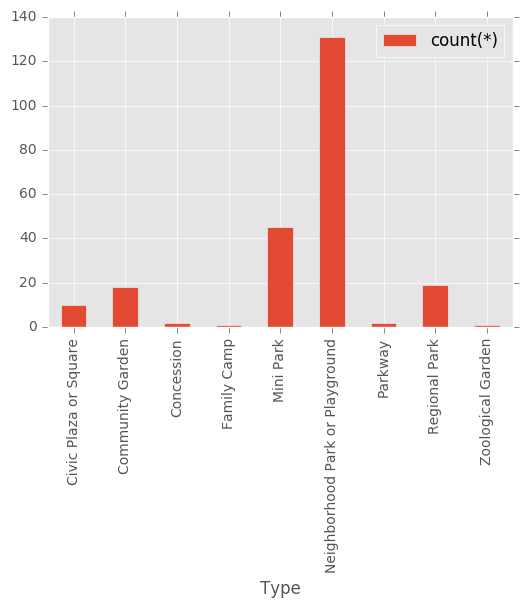

In [99]:
selected_table.plot.bar(x=selected_table.Type)

The most type of parks in SF is Neighborhood park or Playground. For Zoological Garden or Family Camp, there are only one for each type in SF. Now, we will find the average acreage in each type of park. 

In [100]:
sql_query = """
select Type, avg(Acreage) 
from parks
group by Type;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table

,Type,avg(Acreage)
0,Civic Plaza or Square,4.373000
1,Community Garden,0.316111
2,Concession,43.620000
3,Family Camp,337.510000
4,Mini Park,0.276000
5,Neighborhood Park or Playground,4.422748
6,Parkway,20.740000
7,Regional Park,155.626842
8,Zoological Garden,131.520000


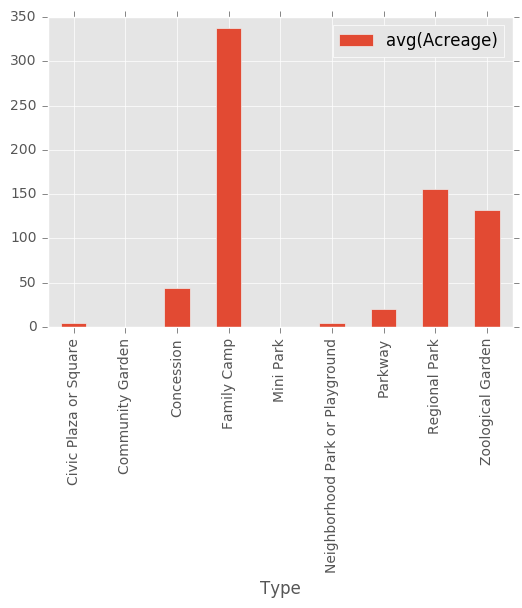

In [101]:
selected_table.plot.bar(x=selected_table.Type)

The park with the largest avearge arceage is the family camp. Regional Park and Zoological Garden parks also have a decend size of average arceage. Although we see the most parks in SF are Neighborhood Park or Playground. However, its average acreage size is very small. The park with the largest arceage is given below. 

In [108]:
sql_query = """
select Type, Acreage, Name from parks
order by Acreage desc;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table[0:10]

,Type,Acreage,Name
0,Regional Park,1031.98,GOLDEN GATE PARK
1,Regional Park,608.49,LAKE MERCED PARK
2,Regional Park,409.69,SHARP PARK
3,Family Camp,337.51,CAMP MATHER
4,Regional Park,312.54,JOHN MCLAREN PARK
5,Regional Park,162.16,YACHT HARBOR AND MARINA GREEN
6,Zoological Garden,131.52,SAN FRANCISCO ZOO
7,Regional Park,112.03,LINCOLN PARK
8,Concession,86.13,CANDLESTICK PARK
9,Regional Park,77.94,GLEN PARK


According to the table above, the largest park is golden gate park. 

### **Q5: How the lower grade school and upper grade school distributed in San Francisco?**

In [112]:
school_inf = pd.read_sql("select Name, Lat, Lon from schools where LowerGrade between 0 and 9", sf_conn)
lonlat1 = pd.concat([school_inf['Lat'], school_inf['Lon']], axis = 1)
SF_COORDINATES = (37.7749, -122.4194)
map_1 = folium.Map(SF_COORDINATES, zoom_start=13)
marker_cluster = folium.MarkerCluster("School cluster").add_to(map_1)
for each in lonlat1.iterrows():
    folium.Marker(list((each[1][0], each[1][1]))).add_to(marker_cluster)
map_1

In [111]:
school_inf = pd.read_sql("select Name, Lat, Lon from schools where UpperGrade between 0 and 9", sf_conn)
lonlat1 = pd.concat([school_inf['Lat'], school_inf['Lon']], axis = 1)
SF_COORDINATES = (37.7749, -122.4194)
map_1 = folium.Map(SF_COORDINATES, zoom_start=13)
marker_cluster = folium.MarkerCluster("School cluster").add_to(map_1)
for each in lonlat1.iterrows():
    folium.Marker(list((each[1][0], each[1][1]))).add_to(marker_cluster)
map_1

The two maps above show the distribution of the lower and upper divisions of the schools. We can see there are more upper divisions school near the download district. Let's check what are the type of entity of the schools.  

In [118]:
sql_query = """
select Entity, count(*) as count from schools
group by Entity;
"""
selected_table = pd.read_sql_query(sql_query,sf_conn)
selected_table

,Entity,count
0,Private,304
1,SFCCD,10
2,SFUSD,131


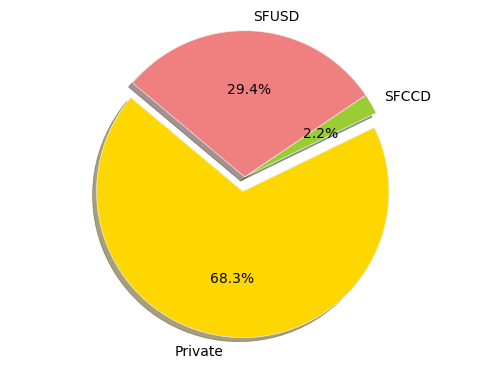

In [137]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Private', 'SFCCD', 'SFUSD'
sizes = [304, 10, 131]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

Therefore, we see most of the schools are private in SF. About 30% of the schools belong to SFUSD. Only around 2% school are SFCCD. 